In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import geopy
from tqdm import tqdm

import scipy.linalg as sla
import seaborn as sns
from sklearn.linear_model import LinearRegression as LR
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import HuberRegressor

In [2]:
!pip install geopandas
!pip install geopy
!pip install contextily

In [5]:
df_info = pd.read_excel('/content/Рестораны (2).xlsx')
df_numbers = pd.read_csv('/content/bquxjob_60790811_18d0f25161e.csv')

df_info = df_info.drop(['Последний тип ремоделинга', 'Код канала розничной торговли',
                        'Имя', 'Краткое наименование', 'JDE код', 'Номер магазина',
                        'Группа стран/регионов', 'Адрес', 'Эл. почта', 'Телефон',
                        'Статус', 'Статус workflow-процесса', 'WF-процессов',
                        'Последний тип ремоделинга', 'Последний год ремоделинга',
                        'Следующий тип ремоделинга', 'Следующий год ремоделинга',
                        'Расширение', 'Юридическое лицо франчайзи',
                        'Наименование юридического лица франчайзи'], axis=1)

df_info = df_info.rename(columns={'Внешний код Facts number': 'Fact ID',
                        'Цепочка компаний': 'Company Chain',
                        'Сабдивизион': 'Subdivision',
                        'Рынок сбыта': 'Market Segment',
                        'Ценовая группа': 'Price Group',
                        'WF-процессов': 'Workflow Processes',
                        'Тип помещения': 'Room Type'})

df_numbers = df_numbers.rename(columns = {'restraunt_id': 'Fact ID'})
df_numbers = df_numbers.drop(['tap_auth_count', 'tap_email_count', 'tap_sms_count'], axis=1)

geolocator = Nominatim(user_agent="http")
df_geo = pd.DataFrame(columns=['Market Segment', 'latitude', 'longitude'])

city_corrections = {
    'Moscow outside MKAD': 'Moscow',
    'Sholokhovo': 'Moscow',
    'Cherepovetc': 'Cherepovets',
    'Pavlovskaya Sloboda': 'Moscow',
    'Vsevolojsk': 'Saint Petersburg',
    'Beloozerskiy': 'Moscow',
    'Vnukovskoye': 'Moscow',
    'Mytischi': 'Moscow',
    'Tolliatty': 'Tolyatti',
    'Nizhniy Tagil': 'Nizhny Tagil',
    'Ozeretskoye': 'Moscow',
    'Novokuybishevsk': 'Samara',
    'Voljskiy': 'Volgograd',
    'Kamensk-Shakhtinskiy': 'Kamensk-Shakhtinsky'
}

for city in tqdm(df_info['Market Segment'].unique()):
    if city in city_corrections:
        city = city_corrections[city]

    city_copy = city

    if city in ['Barnaul', 'Sholokhovo', 'Orenburg', 'Moscow outside MKAD', 'Cherepovetc',
                   'Kemerovo', 'Pavlovskaya Sloboda', 'Vsevolojsk', 'Beloozerskiy', 'Kazan',
                   'Kazan', 'Vnukovskoye', 'Ufa', 'Tula', 'Engels', 'Moscow Region', 'Istra',
                   'Salavat', 'Mytischi', 'Tolliatty', 'Artyom', 'Nizhniy Tagil', 'Ozeretskoye',
                   'Suzdal', 'Marusino', 'Bratsk', 'Nazran', 'Derbent']:
        city += " Russia"

    location = geolocator.geocode(city)

    if location:
        data = {'Market Segment': city_copy, 'latitude': location.latitude, 'longitude': location.longitude}
        add = pd.DataFrame(data, index=[0])
        df_geo = pd.concat([df_geo, add], ignore_index=True)

print(df_geo)

df_info['Market Segment'] = df_info['Market Segment'].replace(city_corrections)

df = df_info.merge(df_geo, on='Market Segment', how='outer').drop_duplicates()
df = df.merge(df_numbers.groupby('Fact ID').agg({'action_order_success': 'sum', 'conversion_rate_total': 'mean'}), on='Fact ID', how='inner')

 55%|█████▍    | 153/280 [01:49<01:31,  1.39it/s]


GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Samara&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))

In [ ]:
price_groups = [
    "Стандарт+50%",
    "Стандарт+5%",
    "Стандарт+30%",
    "Стандарт+20%",
    "Стандарт+15%",
    "Стандарт+10%",
    "Стандарт",
    "Смартбокс+20%",
    "Смартбокс",
    "Сибирь"
]

data = df.copy()

for i in range(data['Fact ID'].count()):
  if data['Price Group'].iloc[i] not in price_groups:
    data['Price Group'].iloc[i] = 0

data = data.drop(['Subdivision', 'Company Chain'], axis=1)
data['Price Group'] = data['Price Group'].astype(str)


from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
data['Price Group'] = pd.DataFrame({"Price Group": labelencoder.fit_transform(data['Price Group'])})
data['Room Type'] = pd.DataFrame({"Room Type": labelencoder.fit_transform(data['Room Type'])})

<ipython-input-4-dea2fe562b6b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Price Group'].iloc[i] = 0


In [ ]:
# @title Препроцессинг
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

class Preproccess:
  def __init__(self, data):
    self.data = data

  # Преобразование нечисловых признаков
  def encoding(self):
    data = self.data.copy()
    dum = pd.get_dummies(data, drop_first=True)
    return dum

  def normalization(self):
    data = self.data.copy()
    normalizer = preprocessing.MinMaxScaler()
    real_norm_np = normalizer.fit_transform(data)
    data = pd.DataFrame(data=real_norm_np)

    return data

  def preprocess(self):
    self.data = self.encoding()
    self.data = self.normalization()
    return self.data

In [ ]:
data.head()

,Fact ID,Market Segment,Price Group,Room Type,latitude,longitude,action_order_success,conversion_rate_total
0,74020442,Moscow,0,3,55.750541,37.617478,48335,0.763231
1,74020460,Moscow,0,4,55.750541,37.617478,3873,0.767060
2,74020477,Moscow,5,3,55.750541,37.617478,73563,0.684763
3,74020566,Moscow,0,0,55.750541,37.617478,10442,0.789830
4,74020588,Moscow,0,3,55.750541,37.617478,54841,0.814167


In [ ]:
# Сопоставление номеров кластеров с цветами
# Исходный словарь цветов
cluster_colors = {
    0: 'gray', 1: 'darkred', 2: 'blue', 3: 'cadetblue', 4: 'black',
    5: 'lightgreen', 6: 'beige', 7: 'pink', 8: 'green', 9: 'darkpurple',
    10: 'lightgray', 11: 'darkblue', 12: 'orange', 13: 'red', 14: 'lightblue',
    15: 'lightred', 16: 'darkgreen', 17: 'white', 18: 'purple',
    19: 'gray', 20: 'darkred', 21: 'blue', 22: 'cadetblue', 23: 'black',
    24: 'lightgreen', 25: 'beige', 26: 'pink', 27: 'green', 28: 'darkpurple',
    29: 'lightgray', 30: 'darkblue', 31: 'orange', 32: 'red', 33: 'lightblue',
    34: 'lightred', 35: 'darkgreen', 36: 'white', 37: 'purple',
    38: 'gray', 39: 'darkred', 40: 'blue', 41: 'cadetblue', 42: 'black',
    43: 'lightgreen', 44: 'beige', 45: 'pink', 46: 'green', 47: 'darkpurple',
    48: 'lightgray', 49: 'darkblue', 50: 'orange', 51: 'red', 52: 'lightblue',
    53: 'lightred', 54: 'darkgreen', 55: 'white', 56: 'purple'
}

In [ ]:
data

,Fact ID,Market Segment,Price Group,Room Type,latitude,longitude,action_order_success,conversion_rate_total
0,74020442,Moscow,0,3,55.750541,37.617478,48335,0.763231
1,74020460,Moscow,0,4,55.750541,37.617478,3873,0.767060
2,74020477,Moscow,5,3,55.750541,37.617478,73563,0.684763
3,74020566,Moscow,0,0,55.750541,37.617478,10442,0.789830
4,74020588,Moscow,0,3,55.750541,37.617478,54841,0.814167
...,...,...,...,...,...,...,...,...
1145,74321914,Voronezh,0,3,51.679931,39.183756,22263,0.765804
1146,74321915,Voronezh,0,0,51.679931,39.183756,13567,0.762171
1147,74321910,Kursk,0,0,69.600000,37.566667,10971,0.806857
1148,74321911,Kursk,0,0,69.600000,37.566667,17497,0.801337


In [ ]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=5)
pca.fit(data[['Room Type', 'latitude', 'longitude', 'action_order_success', 'conversion_rate_total']])
pca.transform(data[['Room Type', 'latitude', 'longitude', 'action_order_success', 'conversion_rate_total']])
pca.explained_variance_ratio_

array([9.99993065e-01, 6.65289679e-06, 2.54436365e-07, 2.73876002e-08,
       5.73935813e-11])

In [ ]:
# @title k mean (unactive)
# Выполните кластеризацию
k_means = KMeans(init="random", n_clusters=30, n_init='auto', algorithm='auto')
data['Cluster'] = k_means.fit_predict(data.iloc[:, 4:6])

# Сопоставление номеров кластеров с цветами
# Исходный словарь цветов
cluster_colors = {
    0: 'gray', 1: 'darkred', 2: 'blue', 3: 'cadetblue', 4: 'black',
    5: 'lightgreen', 6: 'beige', 7: 'pink', 8: 'green', 9: 'darkpurple',
    10: 'lightgray', 11: 'darkblue', 12: 'orange', 13: 'red', 14: 'lightblue',
    15: 'lightred', 16: 'darkgreen', 17: 'white', 18: 'purple',
    19: 'gray', 20: 'darkred', 21: 'blue', 22: 'cadetblue', 23: 'black',
    24: 'lightgreen', 25: 'beige', 26: 'pink', 27: 'green', 28: 'darkpurple',
    29: 'lightgray', 30: 'darkblue', 31: 'orange', 32: 'red', 33: 'lightblue',
    34: 'lightred', 35: 'darkgreen', 36: 'white', 37: 'purple',
    38: 'gray', 39: 'darkred', 40: 'blue', 41: 'cadetblue', 42: 'black',
    43: 'lightgreen', 44: 'beige', 45: 'pink', 46: 'green', 47: 'darkpurple',
    48: 'lightgray', 49: 'darkblue', 50: 'orange', 51: 'red', 52: 'lightblue',
    53: 'lightred', 54: 'darkgreen', 55: 'white', 56: 'purple'
}


# Создание базовой карты
m = folium.Map(location=[60, 100], zoom_start=3)

# Итерация по каждой строке датафрейма и добавление маркера на карту
for index, row in data.iterrows():
    cluster_color = cluster_colors[row['Cluster']]
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=f"{row[['Market Segment', 'Cluster', 'action_order_success']]} ({cluster_color})",
        icon=folium.Icon(color=cluster_color)
    ).add_to(m)

# Отображение карты
m

In [ ]:
from sklearn.cluster import KMeans

def kmean(data, norm, features, init, n_clusters, n_init, old_cluster, old_cluster_name, new_cluster_name):
  data_ = data.copy()
  data = data.copy()

  if old_cluster_name != 'none':
    data = data[data[old_cluster_name] == old_cluster]
    data_ = data[data[old_cluster_name] == old_cluster]

  if norm == True:
    normalizer = preprocessing.MinMaxScaler()
    data[features] = normalizer.fit_transform(data[features])

  clustering = KMeans(init=init, n_clusters=n_clusters, n_init=n_init)
  data_[new_cluster_name] = clustering.fit_predict(data[features])

  m = folium.Map(location=[60, 100], zoom_start=3)

  # Итерация по каждой строке датафрейма и добавление маркера на карту
  for index, row in data_.iterrows():
      cluster_color = cluster_colors[row[new_cluster_name]]
      folium.Marker(
          [row['latitude'], row['longitude']],
          popup=f"{row[['Market Segment', 'Room Type', new_cluster_name, 'action_order_success', 'conversion_rate_total']]} ({cluster_color})",
          icon=folium.Icon(color=cluster_color)
      ).add_to(m)

  # Отображение карты
  return data_, m

In [ ]:
from sklearn.cluster import DBSCAN
import folium

def dbscan(data, norm, features, eps, min_samples, old_cluster, old_cluster_name, new_cluster_name):
  data_ = data.copy()
  data = data.copy()

  if old_cluster_name != 'none':
    data = data[data[old_cluster_name] == old_cluster]
    data_ = data_[data_[old_cluster_name] == old_cluster]

  if norm == True:
    normalizer = preprocessing.MinMaxScaler()
    data[features] = normalizer.fit_transform(data[features])

  clustering = DBSCAN(eps=eps, min_samples=min_samples)
  data_[new_cluster_name] = clustering.fit_predict(data[features])

  m = folium.Map(location=[60, 100], zoom_start=3)

  # Итерация по каждой строке датафрейма и добавление маркера на карту
  for index, row in data_.iterrows():
      if row[new_cluster_name] > -1: # удаление шумов
        cluster_color = cluster_colors[row[new_cluster_name]]
        folium.Marker(
            [row['latitude'], row['longitude']],
            popup=f"{row[['Market Segment', 'Room Type', new_cluster_name, 'action_order_success', 'conversion_rate_total']]} ({cluster_color})",
            icon=folium.Icon(color=cluster_color)
        ).add_to(m)

  # Отображение карты
  return data_, m

def aa_test(data, feature):

In [ ]:
data_1, m = kmean(data, False, ['Room Type'], 'k-means++', 5, 5, 'none', 'none', 'Room Type Cluster')
m

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA(whiten=True)
data_1 = data_1[data_1['Room Type Cluster'] == 0]
pca.fit(data_1[['Room Type', 'Room Type Cluster', 'latitude', 'longitude', 'action_order_success', 'conversion_rate_total']])
pca.transform(data_1[['Room Type', 'Room Type Cluster', 'latitude', 'longitude', 'action_order_success', 'conversion_rate_total']])
print(pca.explained_variance_ratio_)
print(pca.get_covariance())

[9.99994274e-01 5.53322500e-06 1.92542352e-07 4.98726519e-11
 7.27931961e-34 0.00000000e+00]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.53251960e-17 -1.91947765e-05  1.69064264e-04
  -8.58613012e-01 -6.99723897e-07]
 [ 0.00000000e+00 -1.91947765e-05  3.86560522e+06 -3.40504340e+07
   1.72891091e+11  1.40900404e+05]
 [ 0.00000000e+00  1.69064264e-04 -3.40504340e+07  3.00079645e+08
  -1.52279222e+12 -1.24108917e+06]
 [ 0.00000000e+00 -8.58613012e-01  1.72891091e+11 -1.52279222e+12
   7.73369833e+15  6.30255116e+09]
 [ 0.00000000e+00 -6.99723897e-07  1.40900404e+05 -1.24108917e+06
   6.30255116e+09  5.13628113e+03]]


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_base.py:125: RuntimeWarning: invalid value encountered in divide
  X_transformed /= np.sqrt(self.explained_variance_)


In [ ]:
data_2, m = dbscan(data_1, False, ['latitude', 'longitude'], 1, 5, 3, 'Room Type Cluster', 'Cordinate Cluster')
m

In [ ]:
cat_features_mask = (data_2.dtypes == "object").values

    # для вещественнозначных признаков заполним пропуски средними
d = data_2[data_2.columns[~cat_features_mask]]
d = d.drop('Fact ID', axis=1)
d.head(3)

,Price Group,Room Type,latitude,longitude,action_order_success,conversion_rate_total,Room Type Cluster,Cordinate Cluster
1,0,4,55.750541,37.617478,3873,0.767060,3,0
13,4,4,55.750541,37.617478,11183,0.763868,3,0
31,4,4,55.750541,37.617478,4930,0.734749,3,0


In [ ]:
def pca(data):
  d = and
pca = decomposition.PCA(n_components=1)
normalizer = preprocessing.MinMaxScaler()
d = normalizer.fit_transform(d)
pca.fit(d)
pca.transform(d)
print(pca.explained_variance_ratio_)
print(pca.components_)

[0.36493991]
[[-4.90704542e-01 -2.22044605e-16 -1.41072998e-01  1.40603723e-01
  -6.56646315e-02 -5.88995930e-02 -0.00000000e+00  8.43656950e-01]]


In [ ]:
pd.DataFrame(d)

,0,1,2,3,4,5,6,7
0,0.000000,0.0,0.607413,0.070391,0.097240,0.875454,0.0,0.25
1,0.444444,0.0,0.607413,0.070391,0.365881,0.869424,0.0,0.25
2,0.444444,0.0,0.607413,0.070391,0.136085,0.814401,0.0,0.25
3,0.444444,0.0,0.607413,0.070391,0.049796,0.564533,0.0,0.25
4,0.444444,0.0,0.607413,0.070391,0.298262,0.784111,0.0,0.25
...,...,...,...,...,...,...,...,...
98,1.000000,0.0,0.227476,0.090135,0.180846,0.810067,0.0,0.00
99,0.000000,0.0,0.489897,0.155168,0.271434,0.695396,0.0,0.00
100,0.444444,0.0,0.491806,0.172848,0.175664,0.728110,0.0,0.00
101,0.444444,0.0,0.000000,0.170133,0.063724,0.195555,0.0,0.00


In [ ]:
d[np.array(d.columns)]

,Price Group,Room Type,latitude,longitude,action_order_success,conversion_rate_total,Room Type Cluster,Cordinate Cluster


In [ ]:
data_2, m = dbscan(data_1, False, ['action_order_success'], 150, 5, 0, 'Cordinate Cluster', 'Moscow Cordinate Cluster')
m

In [ ]:
data_3, m = kmean(data_2, False, ['Room Type'],  "k-means++", 5, 10, 3, 'Moscow Cordinate Cluster', 'Room Type Cluster')
m

In [ ]:
data_2

,Fact ID,Market Segment,Price Group,Room Type,latitude,longitude,action_order_success,conversion_rate_total,Cordinate Cluster,Moscow Cordinate Cluster
0,74020442,Moscow,0,3,55.750541,37.617478,48335,0.763231,0,0
1,74020460,Moscow,0,4,55.750541,37.617478,3873,0.767060,0,0
2,74020477,Moscow,5,3,55.750541,37.617478,73563,0.684763,0,0
3,74020566,Moscow,0,0,55.750541,37.617478,10442,0.789830,0,0
4,74020588,Moscow,0,3,55.750541,37.617478,54841,0.814167,0,0
...,...,...,...,...,...,...,...,...,...,...
1062,74321853,Zhukovsky,4,3,55.569173,38.116802,14165,0.817235,0,-1
1101,74321834,Yegoryevsk,4,3,55.382976,39.035622,8496,0.733255,0,-1
1118,74321855,Lytkarino,4,0,55.578138,37.902384,11651,0.741496,0,3
1122,74321863,Kashira,4,0,54.837449,38.150512,9753,0.739116,0,-1


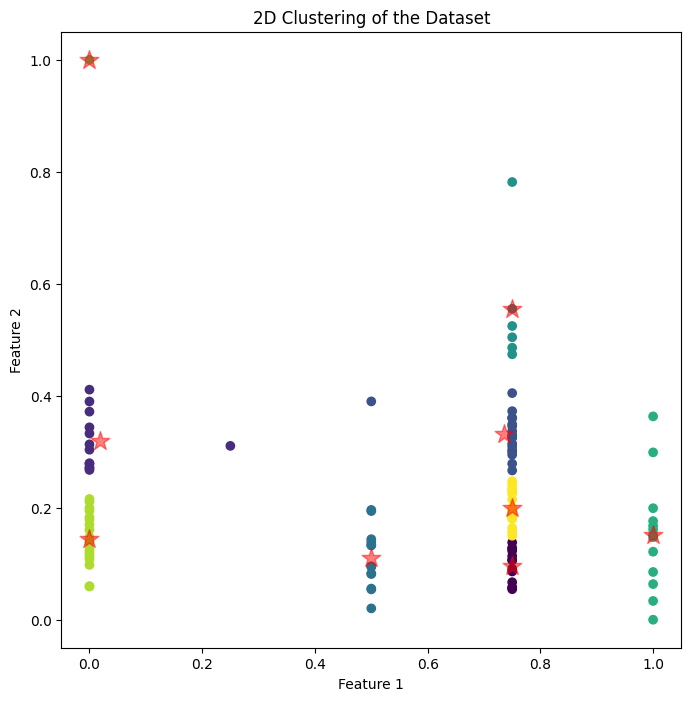

(111,)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Используем данные DataFrame для 2D кластеризации.
data_to_cluster_2d = real_norm_np  # Первые два столбца данных

# 2D Кластеризация с помощью KMeans
k_means_2d = KMeans(init="k-means++", n_clusters=9, n_init=10)
k_means_2d.fit(data_to_cluster_2d)

# Создаем график для 2D кластеризации
plt.figure(figsize=(8, 8))
plt.scatter(data_to_cluster_2d[:, 0], data_to_cluster_2d[:, 1], c=k_means_2d.labels_, cmap='viridis')
plt.scatter(k_means_2d.cluster_centers_[:, 0], k_means_2d.cluster_centers_[:, 1], c='red', s=200, alpha=0.5, marker='*')
plt.title('2D Clustering of the Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

k_means_2d.labels_.shape